In [19]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
from datetime import date
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# no warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
label = "priceRange"

In [21]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(TEST_PATH)

In [22]:
train.head(1)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,MULTIPLE OFFERS submit best & final to Agent b...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.0,17,4.0,4,650000+


In [27]:
temp = tf.strings.split(train.description.head())

In [28]:
temp

<tf.RaggedTensor [[b'MULTIPLE', b'OFFERS', b'submit', b'best', b'&', b'final', b'to', b'Agent', b'by', b'Mon', b'21st', b'-', b'5pm.', b'Appt', b'with', b'Agent.', b'RARE', b'PANORAMIC', b'VIEW', b'LOT', b'IN', b'JESTER', b'ESTATES', b'SEE', b'FOR', b'MILES!!', b'Home', b'sits', b'on', b'Cul-de-sac', b'&', b'backs', b'to', b'a', b'Preserve.', b'Stunning', b'remodeled', b'Kitchen', b'&', b'Bathrooms.', b'Master', b'suite', b'is', b'a', b'private', b'sanctuary', b'with', b'chic', b'master', b'bath,', b'huge', b'bedroom,', b'walk-in', b'closet', b'&', b'private', b'deck.', b'Jester', b'has', b'a', b'pool,', b'park,', b'tennis', b'courts', b'&', b'feeds', b'into', b'Anderson', b'High.', b'This', b'home', b'has', b'been', b'well', b'loved', b'&', b'features', b'3', b'living', b'areas,', b'an', b'office,', b'&', b'3', b'car', b'garage.'], [b'4644', b'Hoffman', b'Dr,', b'Austin,', b'TX', b'78749', b'is', b'a', b'single', b'family', b'home', b'that', b'contains', b'2,059', b'sq', b'ft', b'and'

In [29]:
tf.strings.ngrams(temp, 2)

<tf.RaggedTensor [[b'MULTIPLE OFFERS', b'OFFERS submit', b'submit best', b'best &', b'& final', b'final to', b'to Agent', b'Agent by', b'by Mon', b'Mon 21st', b'21st -', b'- 5pm.', b'5pm. Appt', b'Appt with', b'with Agent.', b'Agent. RARE', b'RARE PANORAMIC', b'PANORAMIC VIEW', b'VIEW LOT', b'LOT IN', b'IN JESTER', b'JESTER ESTATES', b'ESTATES SEE', b'SEE FOR', b'FOR MILES!!', b'MILES!! Home', b'Home sits', b'sits on', b'on Cul-de-sac', b'Cul-de-sac &', b'& backs', b'backs to', b'to a', b'a Preserve.', b'Preserve. Stunning', b'Stunning remodeled', b'remodeled Kitchen', b'Kitchen &', b'& Bathrooms.', b'Bathrooms. Master', b'Master suite', b'suite is', b'is a', b'a private', b'private sanctuary', b'sanctuary with', b'with chic', b'chic master', b'master bath,', b'bath, huge', b'huge bedroom,', b'bedroom, walk-in', b'walk-in closet', b'closet &', b'& private', b'private deck.', b'deck. Jester', b'Jester has', b'has a', b'a pool,', b'pool, park,', b'park, tennis', b'tennis courts', b'court

In [23]:
train.shape

(10000, 16)

In [6]:
classes = train[label].unique().tolist()
print(f"Label classes: {classes}")

train[label] = train[label].map(classes.index)

Label classes: ['650000+', '350000-450000', '0-250000', '450000-650000', '250000-350000']


In [7]:
train.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange'],
      dtype='object')

In [8]:
test.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms'],
      dtype='object')

# Train

In [9]:
train.description

0       MULTIPLE OFFERS submit best & final to Agent b...
1       4644 Hoffman Dr, Austin, TX 78749 is a single ...
2       6804 Canal St, Austin, TX 78741 is a single fa...
3       Beautiful large lot with established trees. Lo...
4       Stunning NW Hills designer remodel by Cedar an...
                              ...                        
9995    Updated Great Hills Opportunity! Large corner ...
9996    Adorable 3/2 in the heart of South Austin! Sit...
9997    7322 Gaines Mill Ln, Austin, TX 78745 is a sin...
9998    5213 Doe Valley Ln, Austin, TX 78759 is a sing...
9999    Beautiful single-story home with open floor pl...
Name: description, Length: 10000, dtype: object

In [10]:
def inpute_missing(dataset):
    """ 
    Edit this to fix nulls. Default version replaces all int/float with 0
    """
    for col in dataset.columns:
        if dataset[col].dtype not in [str, object]:
            dataset[col] = dataset[col].fillna(dataset[col].mean())
        elif col == 'name':
             dataset[col] = 'No Name'
    return dataset

train = inpute_missing(train)
test = inpute_missing(test)

In [11]:
def nlp_transforms(dataset):
    """ 
    NLP tranforms here. Default, None...
    """
    
    # lower case
    dataset['description'] = dataset['description'].str.lower()
    
    #remove punctuations
    train["description"] = train['description'].str.replace('[^\w\s]','')
    
    # description length (characters)
    
    # description sentiment? 
    
    return dataset

train = nlp_transforms(train)
test = nlp_transforms(test)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uid                         10000 non-null  int64  
 1   city                        10000 non-null  object 
 2   description                 10000 non-null  object 
 3   homeType                    10000 non-null  object 
 4   latitude                    10000 non-null  float64
 5   longitude                   10000 non-null  float64
 6   garageSpaces                10000 non-null  int64  
 7   hasSpa                      10000 non-null  bool   
 8   yearBuilt                   10000 non-null  int64  
 9   numOfPatioAndPorchFeatures  10000 non-null  int64  
 10  lotSizeSqFt                 10000 non-null  float64
 11  avgSchoolRating             10000 non-null  float64
 12  MedianStudentsPerTeacher    10000 non-null  int64  
 13  numOfBathrooms              1000

In [13]:
def computation_transforms(dataset):
    """ 
    New Feature Engineering. Default, None...
    """
    dataset['hasSpa'] = np.where(dataset['hasSpa'] == True, 1, 0)
    return dataset

train = computation_transforms(train)
test = computation_transforms(test)

In [14]:
train.head()

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,multiple offers submit best final to agent by...,Single Family,30.380089,-97.800621,0,0,1988,0,102366.0,7.000000,17,4.0,4,0
1,13380,austin,4644 hoffman dr austin tx 78749 is a single fa...,Single Family,30.199486,-97.859947,0,0,1997,0,6534.0,6.666667,16,3.0,4,1
2,4115,austin,6804 canal st austin tx 78741 is a single fami...,Single Family,30.227398,-97.696083,0,0,1952,0,5619.0,3.333333,11,1.0,2,2
3,6926,austin,beautiful large lot with established trees lov...,Single Family,30.205469,-97.792351,4,0,1976,0,6416.0,4.000000,14,2.0,4,2
4,14480,austin,stunning nw hills designer remodel by cedar an...,Single Family,30.345106,-97.767426,2,0,1984,0,10759.0,7.000000,16,3.0,5,0


# Train

In [74]:
train.head(1)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,multiple offers submit best final to agent by...,Single Family,30.380089,-97.800621,0,0,1988,0,102366.0,7.0,17,4.0,4,0


In [75]:
train.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange'],
      dtype='object')

In [76]:
to_drop = ['uid']
train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

In [77]:
columns = train.columns.tolist()

In [78]:
columns

['city',
 'description',
 'homeType',
 'latitude',
 'longitude',
 'garageSpaces',
 'hasSpa',
 'yearBuilt',
 'numOfPatioAndPorchFeatures',
 'lotSizeSqFt',
 'avgSchoolRating',
 'MedianStudentsPerTeacher',
 'numOfBathrooms',
 'numOfBedrooms',
 'priceRange']

In [79]:
def prepare_dataset(data):
    
    features = {"city" : data["city"],
                "description" : tf.strings.split(data["description"]),
                "homeType" : data["homeType"],
                "latitude" : data["latitude"],
                "longitude" : data["longitude"],
                "garageSpaces" : data["garageSpaces"],
                "hasSpa" : data["hasSpa"],
                "yearBuilt" : data["yearBuilt"],
                "numOfPatioAndPorchFeatures" : data["numOfPatioAndPorchFeatures"],
                "lotSizeSqFt" : data["lotSizeSqFt"],
                "avgSchoolRating" : data["avgSchoolRating"],
                "MedianStudentsPerTeacher" : data["MedianStudentsPerTeacher"],
                "numOfBathrooms" : data["numOfBathrooms"],
                "numOfBedrooms" : data["numOfBedrooms"]
               }
    
    try:
        label = data['priceRange']
        output = features,label
    except:
        output = features
    
    return output

In [80]:
X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

columns = train.columns.tolist()
#columns = ['age','outcome_type']
train_dataframe = X_train[columns]
train_dataframe = train_dataframe.to_dict('list')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataframe)

test_dataframe = X_test[columns]
test_dataframe = test_dataframe.to_dict('list')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataframe)



train_ds = train_dataset.batch(64).map(prepare_dataset)
test_ds = test_dataset.batch(64).map(prepare_dataset)

In [81]:
#train.head()

In [ ]:
model_1 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_1.compile(metrics=[tf.keras.metrics.CategoricalCrossentropy()])
model_1.fit(x=train_ds)

125/125 [==============================] - 1s 906us/step


In [ ]:
#logs

In [ ]:
model_1.make_inspector().evaluation()

In [182]:
model_1.summary()

Model: "gradient_boosted_trees_model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (15):
	age
	animal_type
	birth_month
	birth_year
	breed
	color
	day
	hour
	month
	name
	num_breed
	sex
	spay_neuter
	weekday
	year

No weights

Variable Importance: NUM_NODES:
    1.         "age" 7576.000000 ################
    2.       "breed" 3629.000000 #######
    3. "birth_month" 2854.000000 #####
    4.  "birth_year" 2362.000000 ####
    5.        "hour" 1921.000000 ###
    6.         "day" 1853.000000 ###
    7.       "color" 1764.000000 ###
    8.     "weekday" 1252.000000 ##
    9. "spay_neuter" 703.000000 #
   10. "animal_type" 562.000000 #
   11.       "month" 529.000000 #
   12.         "sex" 27

In [171]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=2)

In [ ]:
model_1.make_inspector().evaluation()

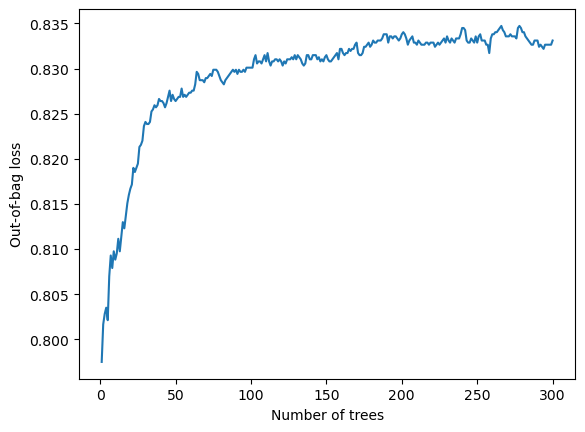

In [172]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

In [175]:
test_ds

<MapDataset shapes: ({breed: (None, None), color: (None, None), name: (None, None), animal_type: (None,), sex: (None,), spay_neuter: (None,), num_breed: (None,), year: (None,), month: (None,), day: (None,), hour: (None,), weekday: (None,), age: (None,), birth_year: (None,), birth_month: (None,)}, (None,)), types: ({breed: tf.string, color: tf.string, name: tf.string, animal_type: tf.string, sex: tf.string, spay_neuter: tf.string, num_breed: tf.int32, year: tf.int32, month: tf.int32, day: tf.int32, hour: tf.int32, weekday: tf.string, age: tf.int32, birth_year: tf.int32, birth_month: tf.int32}, tf.int32)>

In [176]:
train_ds

<MapDataset shapes: ({breed: (None, None), color: (None, None), name: (None, None), animal_type: (None,), sex: (None,), spay_neuter: (None,), num_breed: (None,), year: (None,), month: (None,), day: (None,), hour: (None,), weekday: (None,), age: (None,), birth_year: (None,), birth_month: (None,)}, (None,)), types: ({breed: tf.string, color: tf.string, name: tf.string, animal_type: tf.string, sex: tf.string, spay_neuter: tf.string, num_breed: tf.int32, year: tf.int32, month: tf.int32, day: tf.int32, hour: tf.int32, weekday: tf.string, age: tf.int32, birth_year: tf.int32, birth_month: tf.int32}, tf.int32)>

In [174]:
# all features
evaluation = model_1.evaluate(test_ds)

#print(f"BinaryCrossentropyloss: {evaluation[0]}")
#print(f"Accuracy: {evaluation[1]}")


ValueError: in user code:

    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:514 run_step  *
        outputs = model.test_step(data)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1270 test_step  **
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:460 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/utils/metrics_utils.py:86 decorated
        update_op = update_state_fn(*args, **kwargs)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:664 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [150]:
#model_1.summary()

In [151]:
# only breed
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

171/171 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8295
BinaryCrossentropyloss: 0.0
Accuracy: 0.8295350074768066


In [56]:
## Old Model
evaluation

[0.0, 0.7551920413970947]

In [57]:
evaluation

[0.0, 0.7551920413970947]

# Train on Entire Dataset


In [245]:
train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label)
# A more complex, but possibly, more accurate model.
#models = {
    #'rf_baselines': tfdf.keras.RandomForestModel(),
    #'rf_tune1': tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task = tfdf.keras.Task.REGRESSION),
    #'gbt_baselines': tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION),
#    'gbt_tune1': tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
#    }

models['gbt_tune1'].compile(metrics=["accuracy"])
models['gbt_tune1'].fit(x=train_tf)

851/851 [==============================] - 1s 1ms/step


# Predictions

In [246]:
models

{'rf_baselines': <tensorflow_decision_forests.keras.RandomForestModel at 0x7f50273560a0>,
 'rf_tune1': <tensorflow_decision_forests.keras.RandomForestModel at 0x7f5027356370>,
 'gbt_baselines': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7f5026cb9ac0>,
 'gbt_tune1': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7f5027338f70>}

In [304]:
scores = models['gbt_tune1'].predict(predictions)

In [305]:
#Label classes: ['adoption', 'no outcome', 'transfer']

In [306]:
scores

array([[8.7180000e-04, 9.9736279e-01, 1.7653710e-03],
       [2.0946354e-02, 7.1948725e-01, 2.5956640e-01],
       [9.3595344e-01, 3.3668408e-03, 6.0679663e-02],
       ...,
       [3.3661008e-01, 3.5512988e-02, 6.2787688e-01],
       [9.6797407e-01, 6.9470480e-03, 2.5078943e-02],
       [1.5179572e-01, 8.3186381e-02, 7.6501787e-01]], dtype=float32)

In [307]:
temp = pd.DataFrame(data=scores, columns=["adoption", "no outcome","transfer"])

In [308]:
temp['id'] = submission.id

In [309]:
temp = temp[['id','adoption','no outcome','transfer']]

In [310]:
temp

,id,adoption,no outcome,transfer
0,67473,0.000872,0.997363,0.001765
1,4629,0.020946,0.719487,0.259566
2,13914,0.935953,0.003367,0.060680
3,53131,0.093944,0.219680,0.686376
4,57800,0.585817,0.039921,0.374262
...,...,...,...,...
23312,9347,0.903591,0.038790,0.057620
23313,3781,0.004891,0.022325,0.972784
23314,74693,0.336610,0.035513,0.627877
23315,44987,0.967974,0.006947,0.025079


In [311]:
temp['no outcome'] = np.where(temp['no outcome'] > .96, 1, temp['no outcome'])
temp['adoption'] = np.where(temp['no outcome'] == 1, 0, temp['adoption'])
temp['transfer'] = np.where(temp['no outcome'] == 1, 0, temp['transfer'])

In [312]:
temp['adoption'] = np.where(temp['adoption'] > .96, 1, temp['adoption'])
temp['no outcome'] = np.where(temp['adoption'] == 1, 0, temp['no outcome'])
temp['transfer'] = np.where(temp['adoption'] == 1, 0, temp['transfer'])

In [313]:
temp['transfer'] = np.where(temp['transfer'] > .96, 1, temp['transfer'])
temp['adoption'] = np.where(temp['transfer'] == 1, 0, temp['adoption'])
temp['no outcome'] = np.where(temp['transfer'] == 1, 0, temp['no outcome'])

In [314]:
temp.to_csv('submission.csv', index=False)

In [316]:
!kaggle competitions submit -c sliced-s01e10-playoffs-2 -f submission.csv -m "Best With Names with outcome updates"

100%|█████████████████████████████████████████| 779k/779k [00:00<00:00, 850kB/s]
400 - Bad Request
